# Task 2: Build Time Series Forecasting Models

## Objective
Develop, train, and evaluate time series forecasting models to predict Tesla's future stock prices.

## Models
- ARIMA/SARIMA
- LSTM

## Data Preparation
We will focus on Predicting **Tesla (TSLA)** stock prices.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


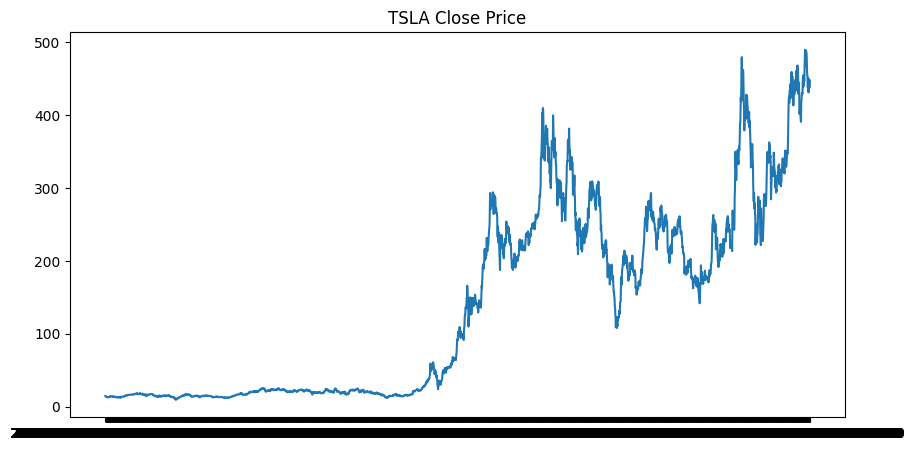

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import importlib
from sklearn.preprocessing import MinMaxScaler

# Add src to path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Reload models to pick up changes
import models
importlib.reload(models)

from data_loader import fetch_data, clean_data
from models import (
    train_test_split_series, 
    fit_arima_model, 
    forecast_and_evaluate,
    create_lstm_sequences,
    build_and_train_lstm,
    forecast_lstm,
    evaluate_forecast
)

# Load Data
data_path = "../data/processed/historical_data.csv"
if os.path.exists(data_path):
    data = pd.read_csv(data_path, index_col=0, parse_dates=True, header=[0, 1]) 
else:
    # Fetch if not exists
    assets = ['TSLA', 'BND', 'SPY']
    data = clean_data(fetch_data(assets, '2015-01-01', '2026-01-15'))

# Filter for TSLA Close
try:
    tsla_close = data['TSLA']['Close']
except:
    tsla_close = data['TSLA'] 

tsla_close.dropna(inplace=True)
plt.figure(figsize=(10, 5))
plt.plot(tsla_close)
plt.title("TSLA Close Price")
plt.show()

## 1. Train/Test Split

Train shape: (2014,)
Test shape: (761,)


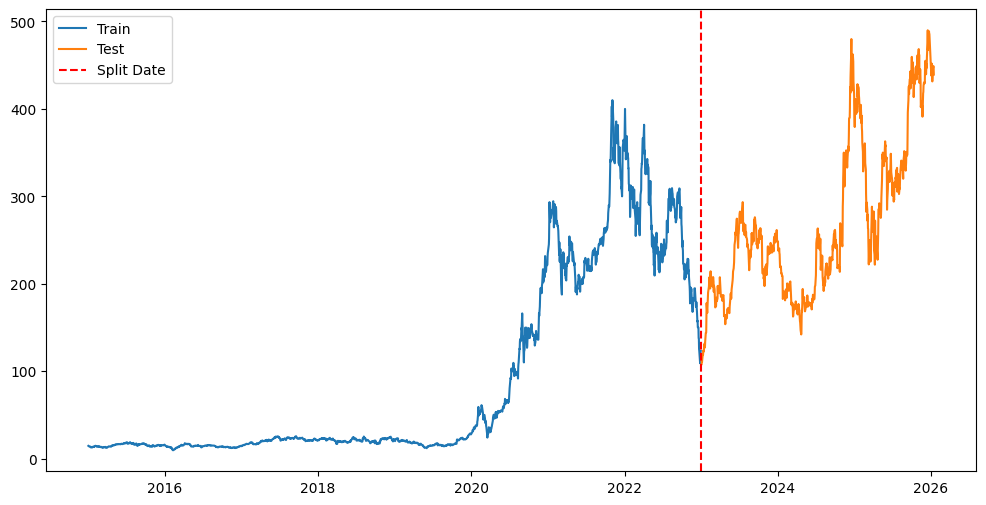

In [35]:
# Split Data
split_date = '2023-01-01'

# Ensure series index and split timestamp share a common timezone (UTC) to avoid mixed timezone errors
# Convert index safely whether it's naive, tz-aware, or mixed by using to_datetime(..., utc=True)
tsla_close = tsla_close.copy()
tsla_close.index = pd.to_datetime(tsla_close.index, utc=True)

# Create a timezone-aware split timestamp in UTC
split_ts = pd.to_datetime(split_date, utc=True)

# Use the timezone-aware timestamp when splitting
train, test = train_test_split_series(tsla_close, split_ts)

plt.figure(figsize=(12,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.axvline(split_ts, color='r', linestyle='--', label='Split Date')
plt.legend()
plt.show()

## 2. ARIMA Model
We use `auto_arima` to find optimal parameters.

INFO:root:Fitting Auto ARIMA model...


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=12588.328, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=12588.157, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=12588.838, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=12588.888, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=12586.350, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[5] intercept   : AIC=12589.637, Time=0.05 sec
 ARIMA(0,1,0)(0,0,1)[5] intercept   : AIC=12589.568, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[5] intercept   : AIC=12584.194, Time=0.41 sec
 ARIMA(0,1,0)(2,0,1)[5] intercept   : AIC=12585.596, Time=0.43 sec
 ARIMA(0,1,0)(1,0,2)[5] intercept   : AIC=12585.541, Time=0.53 sec
 ARIMA(0,1,0)(0,0,2)[5] intercept   : AIC=12584.255, Time=0.24 sec
 ARIMA(0,1,0)(2,0,0)[5] intercept   : AIC=12584.803, Time=0.25 sec
 ARIMA(0,1,0)(2,0,2)[5] intercept   : AIC=12583.604, Time=0.99 sec
 ARIMA(1,1,0)(2,0,2)[5] intercept   : AIC=12581.915, Time=1.68 sec
 ARIMA(1,1,0)(1,0,2

/home/marshy/FOSS/repos/tenx/w9/portfolio-optimization/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/marshy/FOSS/repos/tenx/w9/portfolio-optimization/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/marshy/FOSS/repos/tenx/w9/portfolio-optimization/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/marshy/FOSS/repos/tenx/w9/portfolio-optimization/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_mo

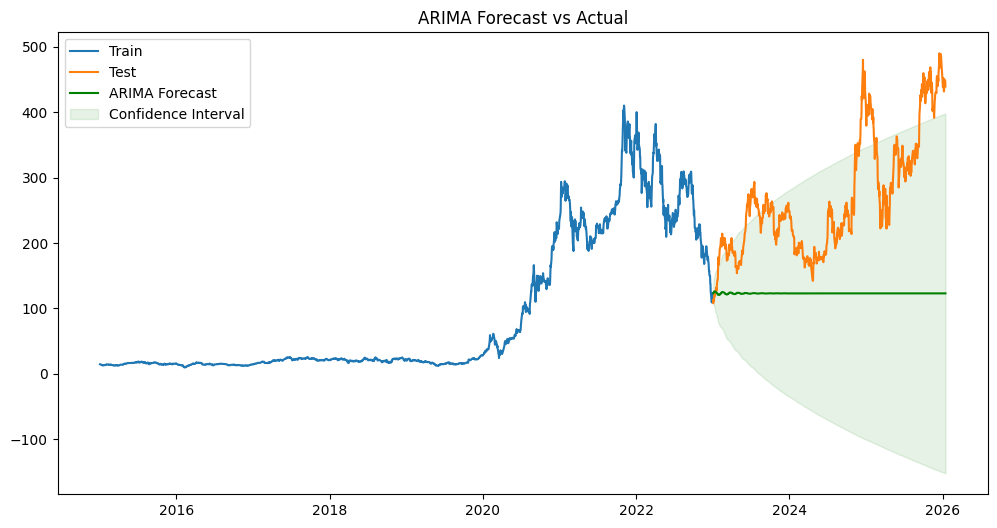

ARIMA Metrics: {'MAE': 147.53058385883608, 'RMSE': np.float64(172.64497169252155), 'MAPE': np.float64(49.68586046348562)}


In [41]:
# Train auto_arima
arima_model = fit_arima_model(train, seasonal=True, m=5)
print(arima_model.summary())

# Forecast and Evaluate
forecast_series, conf_int_df, arima_metrics = forecast_and_evaluate(arima_model, test)

# Plot
plt.figure(figsize=(12,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast_series, label='ARIMA Forecast', color='green')
plt.fill_between(conf_int_df.index, 
                 conf_int_df.iloc[:, 0], 
                 conf_int_df.iloc[:, 1], 
                 color='green', alpha=0.1, label='Confidence Interval')
plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.show()

print("ARIMA Metrics:", arima_metrics)

## 3. LSTM Model

INFO:root:Training LSTM...


Epoch 1/20


E0000 00:00:1769361446.823339  194602 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1769361446.830246  194602 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/marshy/FOSS/repos/tenx/w9/portfolio-optimization/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0047 - val_loss: 0.0040
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.6842e-04 - val_loss: 0.0051
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.0697e-04 - val_loss: 0.0040
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.4695e-04 - val_loss: 0.0037
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.5167e-04 - val_loss: 0.0035
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.9135e-04 - val_loss: 0.0054
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.7958e-04 - val_loss: 0.0031
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.3756e-04 - val_loss: 0.0030
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.4008e-04 - val_loss: 0.0029
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.3596e-04 - val_loss: 0.0038
Epoch 11/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.3943e-04 - val_loss: 0.0028
Epoch 12/20
49/49 ━━━━━━━━━━━━━━━━

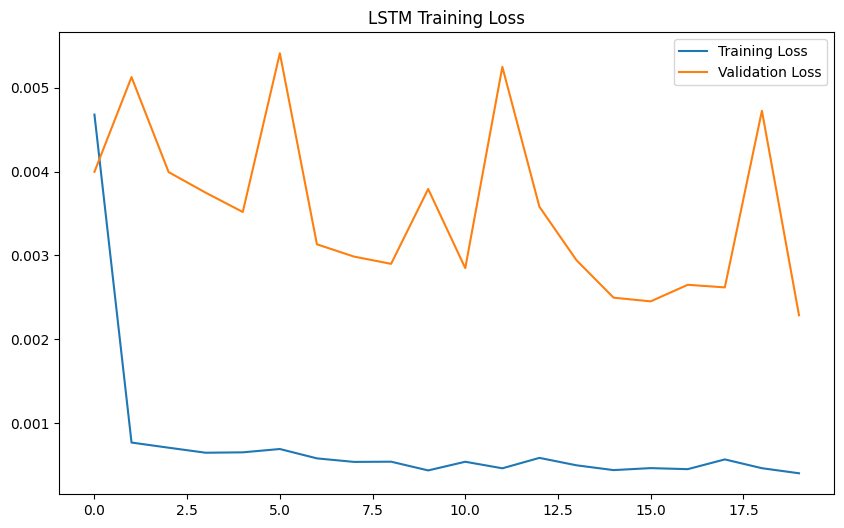

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


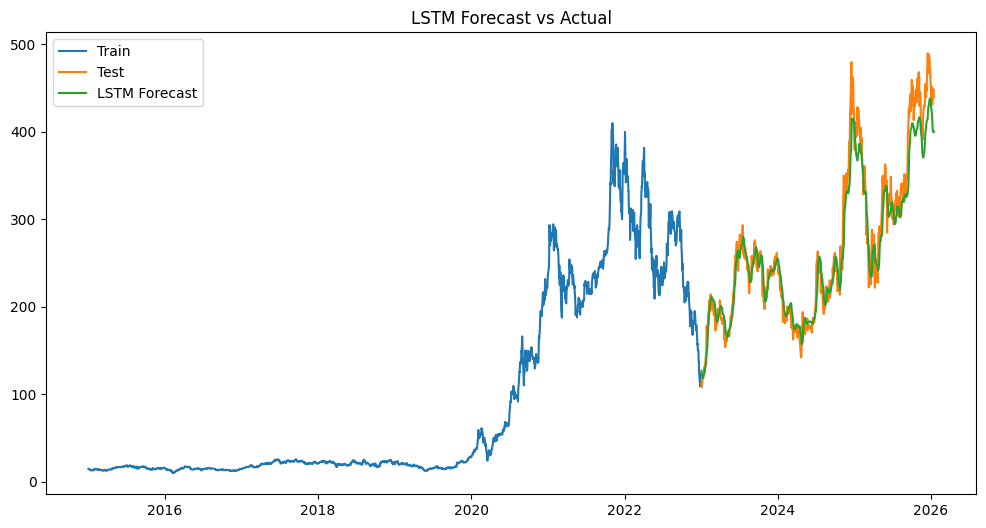


--- LSTM Model Evaluation ---
Mean Absolute Error (MAE): 16.2339
Root Mean Squared Error (RMSE): 22.2609
Mean Absolute Percentage Error (MAPE): 5.64%
LSTM Metrics: {'MAE': 16.233850436517663, 'RMSE': np.float64(22.260904238434165), 'MAPE': np.float64(5.637911732583461)}


In [25]:
# LSTM Preprocessing
seq_length = 60
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale based on training data
scaled_train = scaler.fit_transform(train.values.reshape(-1, 1))

# Create sequences
X_train, y_train = create_lstm_sequences(scaled_train, seq_length)

# Reshape for LSTM (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Train LSTM
# Note: Using small epochs for demo
lstm_model, history = build_and_train_lstm(X_train, y_train, epochs=20, batch_size=32)

# Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training Loss')
plt.legend()
plt.show()

# Forecast LSTM
# We need the full series (or at least train + test) to generate inputs for test forecast
full_data = tsla_close # Original series
forecast_lstm_series = forecast_lstm(lstm_model, full_data, test, scaler, seq_length)

# Plot
plt.figure(figsize=(12,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast_lstm_series, label='LSTM Forecast')
plt.legend()
plt.title("LSTM Forecast vs Actual")
plt.show()

# Evaluate
lstm_metrics = evaluate_forecast(test.values, forecast_lstm_series.values, model_name="LSTM")
print("LSTM Metrics:", lstm_metrics)

## 4. Model Comparison

In [26]:
comparison = pd.DataFrame([arima_metrics, lstm_metrics], index=['ARIMA', 'LSTM'])
print(comparison)


             MAE        RMSE       MAPE
ARIMA  147.26540  172.437669  49.568292
LSTM    16.23385   22.260904   5.637912
